This notebook created a 'data' folder into the current directory. Data-wise, I only uploaded the archive.zip folder to save space. To reproduce the results:
1. Unzip the archive.zip folder externally (it must be in the same directory as the 'ID' folder, not in the 'ID' folder itself because it is also used for Verification)
2. Run this notebook

**Importing libraries**:

In [5]:
import os
from scipy.io import wavfile as wav
import shutil
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

Creating a new folder for ID data, "data_ID", copying all files from "50_speakers_audio_data" into it and setting path variable to the new folder:

In [6]:
if not os.path.isdir(os.getcwd() + '\\data'):
    shutil.copytree(str(Path(os.getcwd()).parent.absolute()) + '\\50_speakers_audio_data',
                    os.getcwd() + '\\data')
    
path = os.getcwd() + '\\data\\'
print(path)

c:\Users\Emili\DSIM_project\ID\data\


## **Selecting tracks**

The data consists of 50 different speakers. For each speaker there's about 1 hour worth of audio signal, divided into 1 min segments. Since we feel that a classification task with that many classes would be too complex we're not gonna keep all of them. The code below removes all files with a format different from .wav and builds a dictionary of the sampling rates and prints the results

In [7]:
sampling_rates = {}
removed_speakers = []
for speaker in os.listdir(path):
  try:
    sampling_rate, _ = wav.read(path + speaker + '/' + os.listdir(path + speaker)[0])
    if sampling_rate not in sampling_rates.keys():
      sampling_rates[sampling_rate] = [speaker]
    else:
      sampling_rates[sampling_rate].append(speaker)
  except:
    removed_speakers.append(speaker)
    shutil.rmtree(path + speaker)

print('Removed speakers (different format):\n', removed_speakers)
for sampling_rate in sampling_rates.keys():
  print(f"sampling rate {sampling_rate} -> {len(sampling_rates[sampling_rate])} speakers")

Removed speakers (different format):
 ['Speaker0035', 'Speaker0036', 'Speaker0043', 'Speaker0044', 'Speaker0048', 'Speaker0049', 'Speaker_0020']
sampling rate 22050 -> 19 speakers
sampling rate 16000 -> 24 speakers


Let's keep the data from users with only one type of sampling rate. We'll choose the most common one, which is 16000 Hz

In [8]:
sampling_rate = 16000

In [9]:
removed_speakers = []
for speaker in os.listdir(path):
    if speaker not in sampling_rates[sampling_rate]:
        shutil.rmtree(path + speaker)
        removed_speakers.append(speaker)
        
print('Removed speakers (different sampling rate):\n', removed_speakers)

Removed speakers (different sampling rate):
 ['Speaker0026', 'Speaker0027', 'Speaker0028', 'Speaker0029', 'Speaker0030', 'Speaker0031', 'Speaker0032', 'Speaker0033', 'Speaker0034', 'Speaker0037', 'Speaker0038', 'Speaker0039', 'Speaker0040', 'Speaker0041', 'Speaker0042', 'Speaker0045', 'Speaker0046', 'Speaker0047', 'Speaker0050']


Our goal is to create a balanced dataset (same number of samples for each class). Let's see how many samples we have for each class. We'll find which class has the minimum amout of tracks and use that number as the number of samples for each class

In [10]:
min_tracks = float('inf')
max_tracks = 0

for speaker in os.listdir(path):
  if len(os.listdir(path + speaker)) < min_tracks:
    min_tracks = len(os.listdir(path + speaker))

  if len(os.listdir(path + speaker)) > max_tracks:
    max_tracks = len(os.listdir(path + speaker))

print('Minimum tracks:', min_tracks)
print('Maximum tracks:', max_tracks)

Minimum tracks: 33
Maximum tracks: 120


Let's make sure that, after selecting the same number of tracks, we have about the same amount of audio for each class

In [11]:
duration_dict = {}
for speaker in os.listdir(path):
  audio_seconds = 0
  for track in os.listdir(path + speaker)[:min_tracks]:
    _, sound_data = wav.read(path + speaker + '/' + track)
    audio_seconds = audio_seconds + sound_data.shape[0]/sampling_rate
  duration_dict[speaker] = audio_seconds
  
print(duration_dict)

{'Speaker_0000': 1980.0319999999992, 'Speaker_0001': 1980.0319999999992, 'Speaker_0002': 1980.0319999999992, 'Speaker_0003': 1980.0319999999992, 'Speaker_0004': 1980.0319999999992, 'Speaker_0005': 1980.0319999999992, 'Speaker_0006': 1980.0319999999992, 'Speaker_0007': 1980.0319999999992, 'Speaker_0008': 1980.0319999999992, 'Speaker_0009': 1980.0319999999992, 'Speaker_0010': 1979.1866875000014, 'Speaker_0011': 1979.1866875000014, 'Speaker_0012': 1979.1605625000013, 'Speaker_0013': 1979.1866875000014, 'Speaker_0014': 1979.1866875000014, 'Speaker_0015': 1979.1866875000014, 'Speaker_0016': 1979.1866875000014, 'Speaker_0017': 1979.1866875000014, 'Speaker_0018': 1979.1866875000014, 'Speaker_0019': 1967.8706250000014, 'Speaker_0021': 1979.1866875000014, 'Speaker_0023': 1979.1866875000014, 'Speaker_0024': 1979.1866875000014, 'Speaker_0025': 1979.1866875000014}


As we can see, each speaker contains roughly 1980 seconds (33 minutes) of audio. We can proceed to keep in the dataset only the first 33 tracks for each speaker in the dataset

In [12]:
removed_tracks = []
for speaker in os.listdir(path):
  track_num = 0
  for track in os.listdir(path + speaker):
    track_num = track_num + 1    
    if track_num > min_tracks:
      os.remove(path + speaker + '/' + track)
      removed_tracks.append(track)

print(f'{len(removed_tracks)} tracks removed:')

732 tracks removed:


Now let's rename speakers and tracks in a consistent way:

In [13]:
speaker_num = 0
for speaker in os.listdir(path):
  speaker_num = speaker_num + 1
  os.rename(path + speaker, path + f"speaker_{str(speaker_num)}")

In [14]:
for speaker in os.listdir(path):
  track_num = 0
  for track in os.listdir(path + speaker):
    track_num = track_num + 1
    os.rename(path + speaker + '/' + track, path + speaker + '/' + f'track_{str(track_num)}.wav')

## **Segmenting tracks**

IDEA: divide each track into 5 second segments and save them in a new folder.
Let's see how short would the last segments be if we do that. We can fix the short segments by adding zeros at the end, but if all final segments are really short maybe it would be better to pick a different segmentation length

In [15]:
track_lengths = []
for speaker in os.listdir(path):
  for track in os.listdir(path + speaker):
    _, sound_data = wav.read(path + speaker + '/' + track)
    track_lengths.append((sound_data.shape[0]/sampling_rate))

Text(0.5, 0, 'final 5 sec segment length')

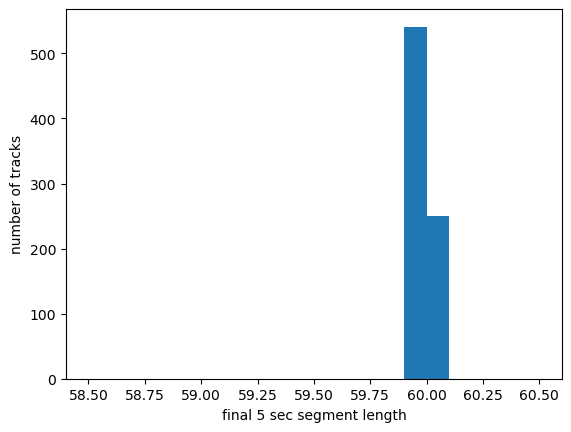

In [16]:
plt.hist(track_lengths, range=(58.5, 60.5), bins=20)
plt.ylabel('number of tracks')
plt.xlabel('final 5 sec segment length')

Looks like there are some segments just few milliseconds longer than 60 seconds. To avoid having a segments having just a few milliseconds worth of signal we are gonna stop after 60 seconds and discard the rest of the track. Let's see how's the final segment length if we cut every 5 seconds after this consideration:

In [17]:
final_segment_lengths_under60 = []
for speaker in os.listdir(path):
  for track in os.listdir(path + speaker):
    _, sound_data = wav.read(path + speaker + '/' + track)
    if sound_data.shape[0]/sampling_rate <= 60: 
      final_segment_lengths_under60.append((sound_data.shape[0]/sampling_rate)%5)

Text(0.5, 0, 'final 5 sec segment length')

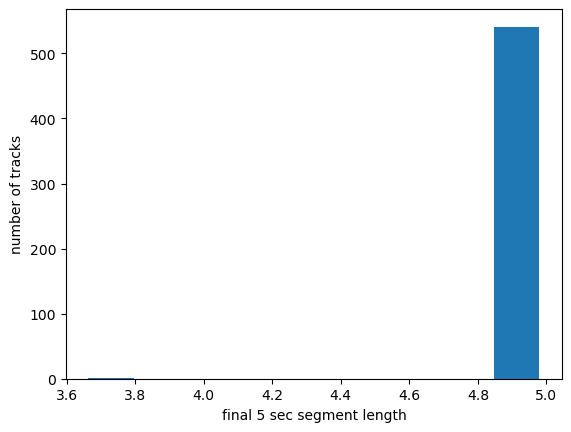

In [18]:
plt.hist(final_segment_lengths_under60)
plt.ylabel('number of tracks')
plt.xlabel('final 5 sec segment length')

Considering only segments <= 60 sec we can see that there's only a very small number of final segments between under 4.8 seconds (and all are above 3.6 seconds, which is 72% of a 5 second segment), so this 5-sec segmentation gives us no issues (even if they were all belonging to the same speaker, the dataset would still be balanced).

Let's define the function that adds zeros at the end of the signal to make it 5 seconds long for the few final instances that would be shorter than 5 seconds (it's important that all tracks have the same length becuase we don't the classifier to learn to distinguish between speakers based on the length of the signal)

In [19]:
def feats_temporal(input, size):
    output = np.concatenate((input, np.zeros(size-input.shape[0])))
    return output

Now, for each speaker, let's replace the 1 min long tracks with 5 sec long segments

In [20]:
for speaker in os.listdir(path):
  track_num = 0
  for track in os.listdir(path + speaker):
    track_num = track_num + 1

    # Getting the 1 minute long track to segment:
    _, sound_data = wav.read(path + speaker + '/' + track)
    
    # Creating the list of 5 sec segments:
    sound_segments = [sound_data[i * sampling_rate: (i+5) * sampling_rate] for i in range(0,60,5)]

    # In case the track is less than 55 seconds long (we don't want empty segments)
    sound_segments = [sound_segment for sound_segment in sound_segments if len(sound_segment)!=0]
    
    # Removing the 1 min long track
    os.remove(path + speaker + '/' + track)

    # Converting them to wav files and saving them into the new path
    segment_num = 0
    for sound_segment in sound_segments:
      segment_num = segment_num + 1
      # Adding zeros if shorter than 5 sec
      sound_segment = feats_temporal(input = sound_segment, size = sampling_rate*5)
      # Saving the segment
      wav.write(path + speaker + '/' + f"track{track_num}_segment{segment_num}.wav",
                sampling_rate, sound_segment)

Let's check one last time if the dataset is balanced, this time looking at the new number of tracks for each user:

In [21]:
for speaker in os.listdir(path):
  print(len(os.listdir(path + speaker)))

396
396
396
396
396
396
396
396
396
396
396
396
394
396
396
396
396
396
396
396
396
396
396
396


As we can see almost every speaker (class) has 396 instances (the
only one that has less tracks has 394 of them), so the dataset is really balanced